# Problem 2: Tensorflow Probability Prediction

Tensorflow-Probability is used to predict the $CO_2$ measurements for the years 2008 to 2018.  $CO_2$ data taken from Mauna Loa, Hawaii between the years 1974 and 2008 was used as training data for the prediction model.  The prediction model uses Structural Time Series (STS) modelling, which expresses a time series as a sum of inividual component functions,

$$
f(t) = f_1 (t) + f_2 (t) + ... + f_n (t) + \epsilon.
$$

where $\epsilon \sim N (0,\sigma^2)$.  Each of these individual functions $f_n(t)$ describe a specific component of the trend.  For example, one function may describe the yearly fluctuations in the data while another describes the overall trend between 1958 and 2018.


This method follows the instructions from [this tutorial](https://blog.tensorflow.org/2019/03/structural-time-series-modeling-in.html) and uses parts of the code provided by this tutorial.

In [1]:
from matplotlib import pylab as plt
import math
import numpy as np
from numpy import genfromtxt

import collections

import tensorflow_probability as tfp
import tensorflow as tf
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.rcParams['figure.dpi'] = 100
fig_num = 1

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


### Load Data

This data is taken from the Mauna Loa Observatory in Hawaii.

The data from the years 1958-1974 are ignored to account for possible issues with the recalibration of the reference gas mixtures used, and other quality control procedures.  We also filter out $CO_2$ data with concentration values less than 0.  These data values represent months without data.

In [2]:
data = genfromtxt('co2_mm_mlo.txt', comments='#',skip_header=266)

co2_by_month = data[:,3]
co2_dates = np.arange("1974-05", "2018-03", dtype="datetime64[M]")

# There are some outlier data points that need to be removed. 
# We identify those points and replace them with averages of the surrounding data points.
for i in range(0,len(co2_by_month)):
    if co2_by_month[i] < 300:
        j = 1
        k = 1
        while co2_by_month[i+j] < 0:
            j = j + 1
        while co2_by_month[i-k] < 0:
            k = k + 1
        co2_by_month[i] = (co2_by_month[i-k] + co2_by_month[i+j])/2


num_forecast_steps = 12 * 10 # Forecast the final ten years, given previous data
co2_training_data = co2_by_month[:-num_forecast_steps]

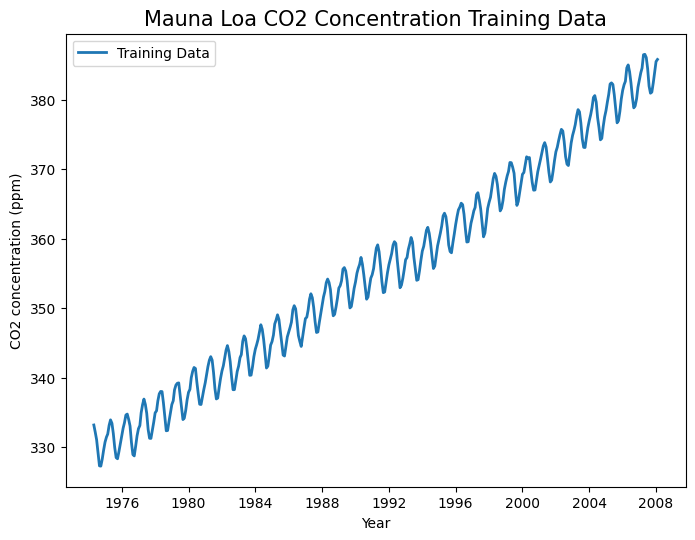

In [3]:
plt.figure(fig_num)
fig_num = fig_num + 1
plt.plot(co2_dates[:-num_forecast_steps], co2_training_data, lw=2, label="Training Data")
plt.ylabel("CO2 concentration (ppm)")
plt.xlabel("Year")
plt.title("Mauna Loa CO2 Concentration Training Data",fontsize=15)
plt.legend()

### Model Data

We can build a model for this data by adding two functions together: the seasonal flucuations and the overall linear trend.

In [4]:
trend = sts.LocalLinearTrend(observed_time_series=co2_training_data)
seasonal = tfp.sts.Seasonal(num_seasons=12, observed_time_series=co2_training_data)

co2_model = sts.Sum([trend, seasonal], observed_time_series=co2_training_data);

Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


The *tfp.sts()* forecasting methods require posterior samples as inputs, so we draw a set of samples from the variational posterior.

In [5]:
# Build the variational surrogate posteriors `qs`.
var_post = tfp.sts.build_factored_surrogate_posterior(model=co2_model)
num_variational_steps = int(200) 

Now we minimize the variational loss

In [6]:
optimizer = tf.optimizers.Adam(learning_rate=.1)
@tf.function(experimental_compile=True)
def train(model, training_data, variational_posteriors, steps):
    loss_curve = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=model.joint_log_prob(observed_time_series=training_data),
        surrogate_posterior=variational_posteriors,
        optimizer=optimizer,
        num_steps=steps)
    return loss_curve


loss_curve = train(co2_model, co2_training_data, var_post, num_variational_steps)

# Draw samples from the variational posterior.
q_samples_co2_ = var_post.sample(50)

### Forecasting

The function *tfp.sts.forecast()* constructs a predictive distribution over future observations.  We can sample this disctribution and take the mean and standard deviation to get a good prediction for the future $CO_2$ values.

In [7]:
co2_forecast_dist = tfp.sts.forecast(
    co2_model,
    observed_time_series=co2_training_data,
    parameter_samples=q_samples_co2_,
    num_steps_forecast=num_forecast_steps)

num_samples=100

co2_forecast_mean = co2_forecast_dist.mean().numpy()[..., 0] 
co2_forecast_scale = co2_forecast_dist.stddev().numpy()[..., 0]
co2_forecast_samples = co2_forecast_dist.sample(num_samples).numpy()[..., 0]

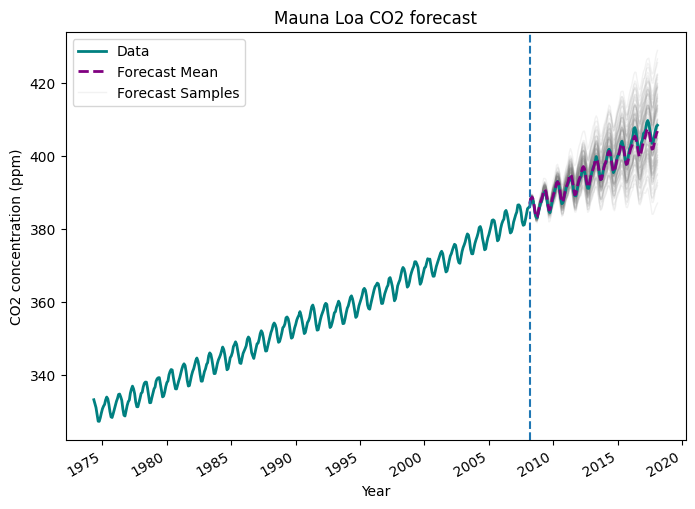

In [8]:
fig = plt.figure(fig_num)
fig_num = fig_num + 1

forecast_steps = np.arange( co2_dates[-num_forecast_steps], co2_dates[-num_forecast_steps]+num_forecast_steps, dtype=co2_dates.dtype)

plt.plot(forecast_steps, co2_forecast_samples.T, color='gray', lw=1, alpha=0.1, label='Forecast Samples')

plt.plot(co2_dates, co2_by_month, lw=2, label='Data', color='teal')
plt.plot(forecast_steps, co2_forecast_mean, lw=2, ls='--',label='Forecast Mean', color='purple')

handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
plt.legend(handles, labels, loc='best')


 
plt.title("Mauna Loa CO2 forecast")
plt.axvline(co2_dates[-num_forecast_steps], linestyle="--")
plt.ylabel("CO2 concentration (ppm)")
plt.xlabel("Year")
fig.autofmt_xdate()